In [1]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import random
import torchaudio.transforms as T
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download latest version
path = kagglehub.dataset_download("ejlok1/cremad")
AUDIO_DIR = os.path.join(path, "AudioWAV/")

# global variables/settings
SR = 16000
DURATION = 5.0
SAMPLES = int(SR * DURATION)
N_MELS = 64
N_FFT = 1024
HOP = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 50
print(f"Using device: {DEVICE}")


Using Colab cache for faster access to the 'cremad' dataset.
Using device: cuda


In [3]:
# emotion labels
emotion_map = {'SAD':'sadness',
               'ANG':'anger',
               'DIS':'disgust',
               'FEA':'fear',
               'HAP':'happiness',
               'NEU':'neutral'}

wav_paths = []
labels = []

print("Collecting files...")
for f in os.listdir(AUDIO_DIR):
    if not f.endswith(".wav"): continue
    parts = f.split("_")
    if len(parts) < 3: continue
    emo = emotion_map.get(parts[2])
    if emo:
        wav_paths.append(os.path.join(AUDIO_DIR, f))
        labels.append(emo)

le = LabelEncoder()
y = le.fit_transform(labels)
class_names = le.classes_
print(f"Classes: {class_names}")
print(f"Total samples: {len(wav_paths)}")


# extract & normalize mel spectrograms
def extract_mel(path):
    audio, _ = librosa.load(path, sr=SR)
    if len(audio) < SAMPLES:
        audio = np.pad(audio, (0, SAMPLES - len(audio)))
    else:
        audio = audio[:SAMPLES]

    mel = librosa.feature.melspectrogram(y=audio, sr=SR, n_fft=N_FFT,
                                         hop_length=HOP, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db.T  # (time, n_mels)

print("Extracting mel-spectrograms...")
mels = []
for p in tqdm(wav_paths):
    mels.append(extract_mel(p))

mels = np.array(mels)  # (N, time, 64)
print("Mels shape:", mels.shape)

mel_mean = mels.mean()
mel_std = mels.std()
mels = (mels - mel_mean) / (mel_std + 1e-8)


Classes: ['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness']
Total samples: 7442
Extracting mel-spectrograms...


100%|██████████| 7442/7442 [01:18<00:00, 94.46it/s]


Mels shape: (7442, 313, 64)


In [4]:
# setup tensor
X_train, X_test, y_train, y_test = train_test_split(mels, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
test_dataset  = TensorDataset(torch.FloatTensor(X_test),  torch.LongTensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# spectral augmentation/masking of frames & mel bins
class SpecAugment(nn.Module):
    def __init__(self, freq_mask=15, time_mask=50, p=0.5):
        super().__init__()
        self.freq_mask = T.FrequencyMasking(freq_mask_param=freq_mask)
        self.time_mask = T.TimeMasking(time_mask_param=time_mask)
        self.p = p

    def forward(self, x):
        if random.random() < self.p:
            x = self.freq_mask(x)
        if random.random() < self.p:
            x = self.time_mask(x)
        return x

spec_augment = SpecAugment()


# gru with attention
class GRUAttention(nn.Module):
    def __init__(self, n_mels=64, hidden=256, layers=3, dropout=0.3, bidir=True):
        super().__init__()
        self.gru = nn.GRU(input_size=n_mels, hidden_size=hidden, num_layers=layers,
                          batch_first=True, bidirectional=bidir,
                          dropout=dropout if layers > 1 else 0)
        self.attn = nn.Linear(hidden * 2 if bidir else hidden, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden * 2 if bidir else hidden, 6)

    def forward(self, x):
        gru_out, _ = self.gru(x)                     # (B, T, hidden*2)
        attn_weights = F.softmax(self.attn(gru_out), dim=1)
        context = torch.sum(gru_out * attn_weights, dim=1)
        out = self.dropout(context)
        return self.fc(out)

# instantiate model
model = GRUAttention().to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)


In [5]:
best_acc = 0
print("\nStarting training...\n")
history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    # train loop
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        xb = spec_augment(xb)
        if random.random() > 0.5:
            xb = xb + torch.randn_like(xb) * 0.075

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        correct += (preds.argmax(1) == yb).sum().item()

    train_acc = correct / len(train_loader.dataset)



    # validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            val_correct += (preds.argmax(1) == yb).sum().item()
    val_acc = val_correct / len(test_loader.dataset)

    history['train_loss'].append(total_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(val_acc)

    scheduler.step(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_crema_d_gru.pth")

    print(f"Epoch {epoch+1:2d} | Loss: {total_loss:.3f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Best: {best_acc:.4f}")

print(f"\nTraining finished! Best validation accuracy: {best_acc:.2%}")
print("Model saved as 'best_crema_d_gru.pth'")



Starting training...

Epoch  1 | Loss: 318.056 | Train: 0.2636 | Val: 0.3452 | Best: 0.3452
Epoch  2 | Loss: 293.330 | Train: 0.3444 | Val: 0.4251 | Best: 0.4251
Epoch  3 | Loss: 283.661 | Train: 0.3764 | Val: 0.4406 | Best: 0.4406
Epoch  4 | Loss: 275.352 | Train: 0.4008 | Val: 0.4392 | Best: 0.4406
Epoch  5 | Loss: 268.463 | Train: 0.4153 | Val: 0.4654 | Best: 0.4654
Epoch  6 | Loss: 265.273 | Train: 0.4273 | Val: 0.4802 | Best: 0.4802
Epoch  7 | Loss: 255.017 | Train: 0.4549 | Val: 0.4862 | Best: 0.4862
Epoch  8 | Loss: 258.269 | Train: 0.4446 | Val: 0.4271 | Best: 0.4862
Epoch  9 | Loss: 250.866 | Train: 0.4594 | Val: 0.4889 | Best: 0.4889
Epoch 10 | Loss: 250.525 | Train: 0.4722 | Val: 0.4815 | Best: 0.4889
Epoch 11 | Loss: 242.343 | Train: 0.4826 | Val: 0.4997 | Best: 0.4997
Epoch 12 | Loss: 238.452 | Train: 0.4920 | Val: 0.5131 | Best: 0.5131
Epoch 13 | Loss: 233.121 | Train: 0.5122 | Val: 0.4909 | Best: 0.5131
Epoch 14 | Loss: 229.979 | Train: 0.5127 | Val: 0.5722 | Best: 0.57


Classification Report:
              precision    recall  f1-score   support

       anger       0.74      0.81      0.78       254
     disgust       0.64      0.57      0.60       254
        fear       0.57      0.52      0.54       254
   happiness       0.61      0.60      0.61       255
     neutral       0.65      0.72      0.68       218
     sadness       0.57      0.59      0.58       254

    accuracy                           0.63      1489
   macro avg       0.63      0.64      0.63      1489
weighted avg       0.63      0.63      0.63      1489



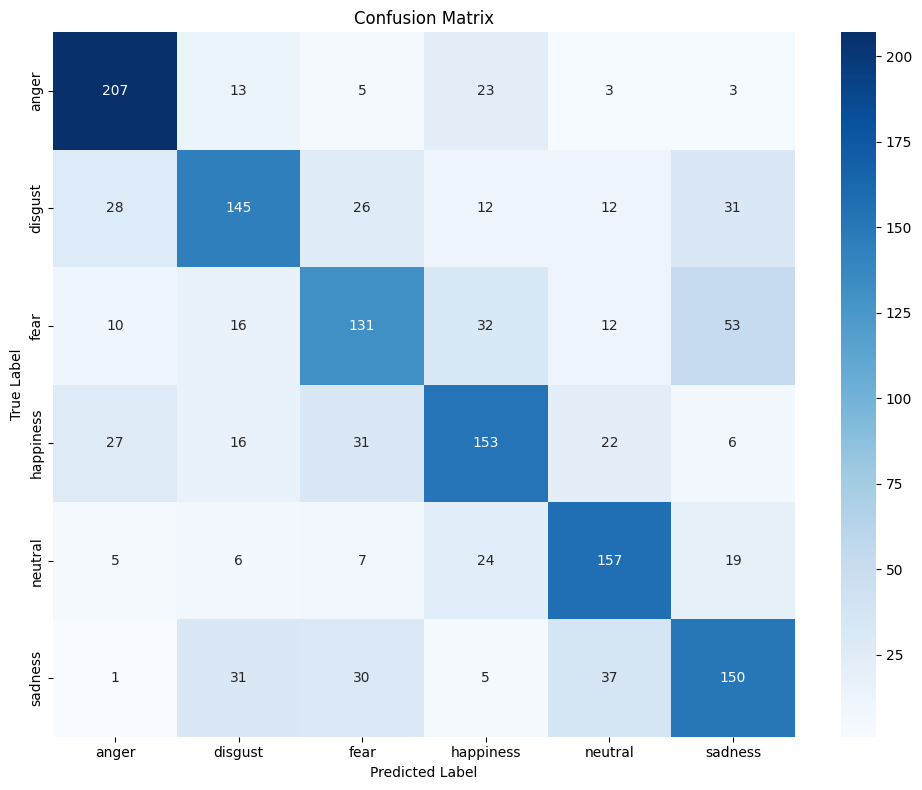

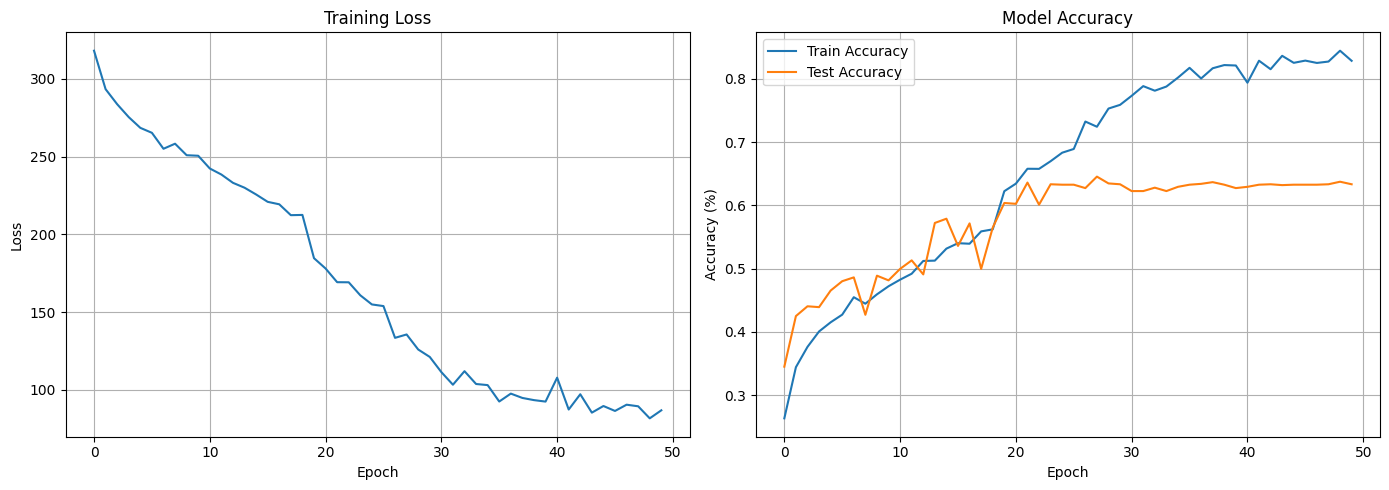


Final Test Accuracy: 0.6333109469442579

Classification Report:
              precision    recall  f1-score   support

       anger       0.74      0.81      0.78       254
     disgust       0.64      0.57      0.60       254
        fear       0.57      0.52      0.54       254
   happiness       0.61      0.60      0.61       255
     neutral       0.65      0.72      0.68       218
     sadness       0.57      0.59      0.58       254

    accuracy                           0.63      1489
   macro avg       0.63      0.64      0.63      1489
weighted avg       0.63      0.63      0.63      1489



In [6]:
# test results & scores
def graph_model(history):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.numpy())

  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=le.classes_))

  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=le.classes_, yticklabels=le.classes_)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.tight_layout()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

  ax1.plot(history['train_loss'])
  ax1.set_title('Training Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.grid(True)

  ax2.plot(history['train_acc'], label='Train Accuracy')
  ax2.plot(history['test_acc'], label='Test Accuracy')
  ax2.set_title('Model Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy (%)')
  ax2.legend()
  ax2.grid(True)

  plt.tight_layout()
  plt.show()


graph_model(history)
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        preds = model(xb).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("\nFinal Test Accuracy:", accuracy_score(all_true, all_preds))
print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=class_names))